In [0]:
import os
import numpy as np
from google.colab import drive
from PIL import Image
from skimage.io import imsave
from tqdm import tqdm

import matplotlib.pyplot as plt

In [0]:
def borders_fun(mask):
    rows, cols = mask.shape
    up = np.zeros((cols,))
    down = np.zeros((cols,))

    for j in range(cols):
        i_up = rows - 1
        i_down = 0
        for i in range(rows):
            if mask[i, j] > 0:
                if i_up > i:
                    i_up = i
                if i_down < i:
                    i_down = i
        up[j] = i_up
        down[j] = i_down

    return up, down

def borders(mask):
    rows, cols = mask.shape
    border = np.zeros_like(mask)

    for j in range(cols):
        i_up = rows - 1
        i_down = 0
        for i in range(rows):
            if mask[i, j] > 0:
                if i_up > i:
                    i_up = i
                if i_down < i:
                    i_down = i

        assert(i_up - i_down < rows - 1)
        if 0 == i_down - i_up:
            border[i_up, j] = 1
        elif 1 <= i_down - i_up <= 3:
            border[i_up:i_down + 1, j] = 1
        else:
            border[i_up:i_up + 2, j] = 1
            border[i_down - 1:i_down + 1, j] = 1

    return border

def sin_shifts(width, double_frequency, amplitude, module=False):
    shifts = amplitude * np.sin(np.pi * double_frequency * np.arange(width) / (width - 1))
    if module:
        shifts = np.abs(shifts)
    return np.round(shifts).astype(np.int)

def double_frequency_gen():
    u = np.random.uniform()
    if u < 0.25:
        return 1
    elif u < 0.75:
        return 2
    elif u < 0.875:
        return 3
    else:
        return 4

def module_gen():
    return False
    u = np.random.uniform()
    if u < 0.3:
        return True
    else:
        return False

def gen_augm_img_mask_border(img, masks, borders, x_mean):
    rows, cols = img.shape
    for i in range(7):
        assert(masks[i].shape == img.shape)
        assert(borders[i].shape == img.shape)

    lim_down = int(np.round(cols / 10))
    lim_up = int(np.round(cols / 4))

    left = np.random.randint(0, cols - lim_down)
    right = np.random.randint(left + lim_down, min(left + lim_up, cols))

    shifts = sin_shifts(right - left,
                        double_frequency_gen(),
                        np.random.randint((right - left) // 8, (right - left) // 4),
                        module_gen())

    augm_img = img.copy()
    augm_masks = [mask.copy() for mask in masks]
    augm_borders = [border.copy() for border in borders]

    for i in range(shifts.shape[0]):
        if shifts[i] > 0:
            augm_img[:-shifts[i], left + 1 + i] = img[shifts[i]:, left + 1 + i]
            augm_img[-shifts[i]:, left + 1 + i] = x_mean[-shifts[i]:, left + 1 + i]
            for k in range(7):
                augm_masks[k][:-shifts[i], left + 1 + i] = masks[k][shifts[i]:, left + 1 + i]
                augm_borders[k][:-shifts[i], left + 1 + i] = borders[k][shifts[i]:, left + 1 + i]
        elif shifts[i] < 0:
            augm_img[-shifts[i]:, left + 1 + i] = img[:shifts[i], left + 1 + i]
            augm_img[:-shifts[i], left + 1 + i] = x_mean[:-shifts[i], left + 1 + i]
            for k in range(7):
                augm_masks[k][-shifts[i]:, left + 1 + i] = masks[k][:shifts[i], left + 1 + i]
                augm_borders[k][-shifts[i]:, left + 1 + i] = borders[k][:shifts[i], left + 1 + i]
        else:
            pass

    return augm_img, augm_masks, augm_borders

In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "./drive/My Drive/Rosneft Seismic/train"

filenames = sorted(filename
                   for filename in os.listdir(f"{path}/images")
                   if filename.startswith("inline"))

In [5]:
data = []
for filename in tqdm(filenames):
    img = np.array(Image.open(f"{path}/images/{filename}"))
    img = img[:, :, :3].mean(axis=2)
    masks = []
    borders = []
    for i in range(7):
        mask = np.array(Image.open(f"{path}/answer/{i}/{filename}"))
        border = np.array(Image.open(f"{path}/answer/{i}_border/{filename}"))
        masks.append(mask)
        borders.append(border)
    data.append((filename, img, masks, borders))

100%|██████████| 512/512 [51:46<00:00,  5.38s/it]


In [0]:
x_mean = np.mean([data[i][1] for i in range(len(data))], axis=0)

In [7]:
for i in tqdm(range(len(data))):
    augm_img, augm_masks, augm_borders = gen_augm_img_mask_border(data[i][1], data[i][2], data[i][3], x_mean)
    imsave(
        f"{path}/images/sinus_{data[i][0]}",
        np.concatenate(
            (
                np.repeat(augm_img[:, :, np.newaxis], 3, axis=2),
                np.ones_like(augm_img[:, :, np.newaxis]) * 255
            ), axis=2).astype(np.uint8))
    for k in range(7):
        imsave(f"{path}/answer/{k}/sinus_{data[i][0]}", augm_masks[k].astype(np.uint8))
        imsave(f"{path}/answer/{k}_border/sinus_{data[i][0]}", augm_borders[k].astype(np.uint8))

100%|██████████| 512/512 [59:33<00:00,  6.78s/it]


# Склад

In [0]:
x_train = np.load(f"{path}/x_train.npy")
y_train = np.load(f"{path}/y_train.npy")

print(x_train.shape, y_train.shape)

(512, 384, 384, 1) (512, 384, 384, 8)


In [0]:
img = x_train[200, :, :, 0]
mask = y_train[200, :, :, 0]
border = borders(y_train[200, :, :, 0])
x_mean = x_train.mean(axis=(0, 3))

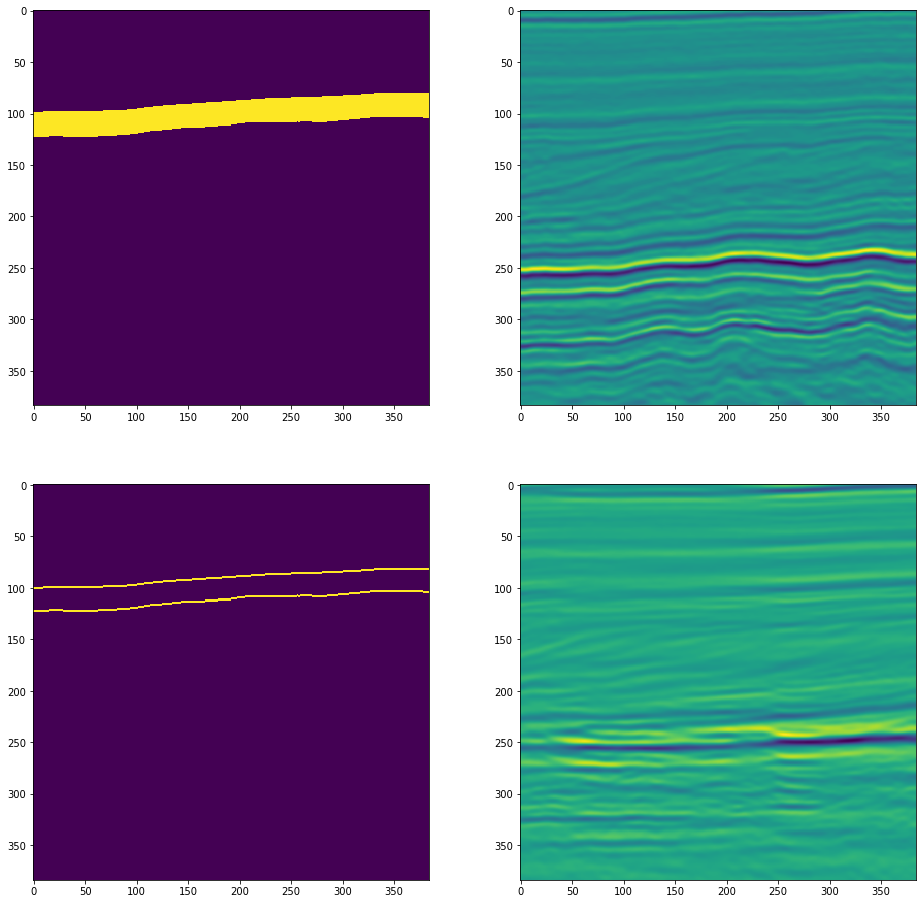

In [0]:
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(mask)
plt.subplot(222)
plt.imshow(img)
plt.subplot(223)
plt.imshow(border)
plt.subplot(224)
plt.imshow(x_mean)
plt.show()
plt.close()

In [0]:
augm_img, augm_mask, augm_border = gen_augm_img_mask_border(img, mask, border, x_mean)

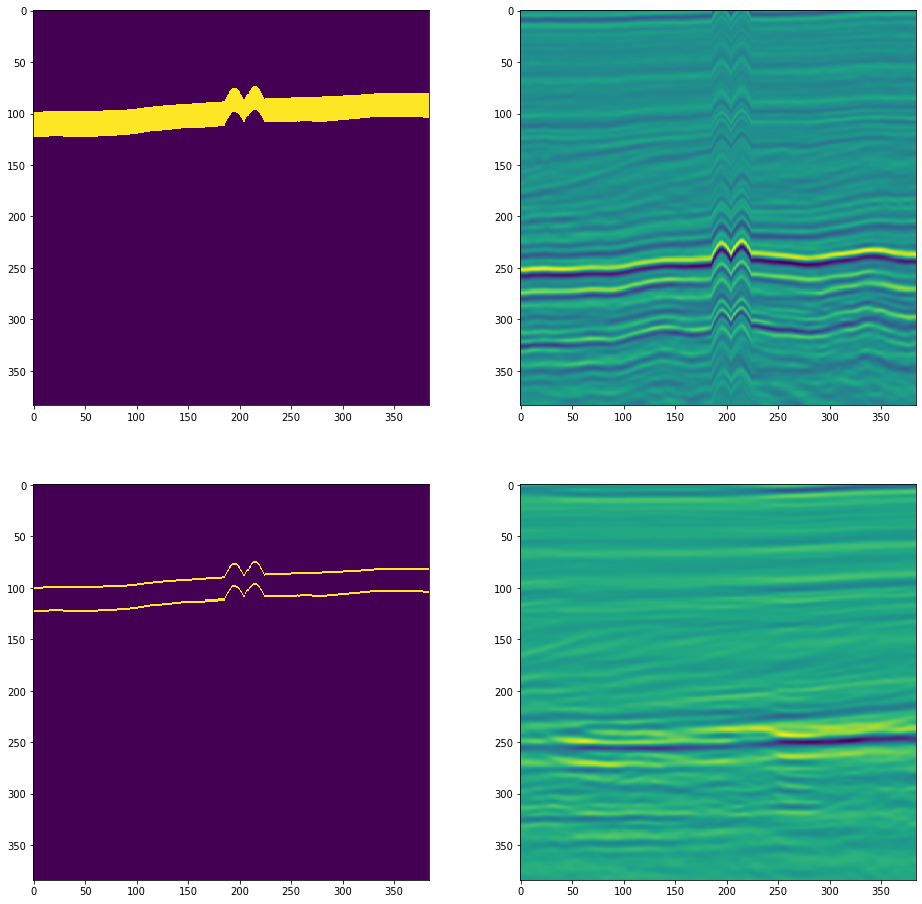

In [0]:
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(augm_mask)
plt.subplot(222)
plt.imshow(augm_img)
plt.subplot(223)
plt.imshow(augm_border)
plt.subplot(224)
plt.imshow(x_mean)
plt.show()
plt.close()

# Random shifts from [-1, 0, 1]

In [0]:
def allowed_shifts_from_diff(diff):
    if 0 == diff:
        return set([-1, 0, 1])
    elif 1 == diff:
        return set([-1, 0])
    elif -1 == diff:
        return set([0, 1])
    else:
        return set([0])

In [0]:
shifts = []
for i in range(left + 1, right - 1):
    allowed_shifts = allowed_shifts_from_diff(up_diff[i - 1]) & allowed_shifts_from_diff(down_diff[i - 1])
    shift = np.random.choice(list(allowed_shifts))
    shifts.append(shift)
shifts = np.array(shifts)

print(shifts.shape)

(41,)
[-1  0  1 -1 -1 -1  1  0 -1 -1 -1  1  1  1  1  1  1  0  0  1  1 -1 -1  1
 -1 -1  1 -1 -1 -1  0  1 -1  1 -1  1  0  1 -1  1  0]


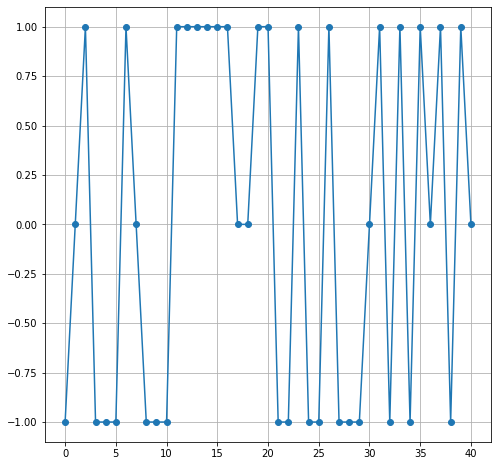

In [0]:
plt.figure(figsize=(8, 8))
plt.plot(shifts, "o-")
plt.grid()
plt.show()
plt.close()

# Functional shifts

In [0]:
def triangle_shifts(width, center, height):
    shifts = np.zeros(width)
    shifts[np.arange(width) <= center] = np.arange(center + 1) * height / center
    shifts[np.arange(width) >= center] = (width - 1 - np.arange(center, width)) * height / (width - 1 - center)
    return np.round(shifts).astype(np.int)

def parabolic_shifts(width, height):
    shifts = height * np.arange(width) * (width - 1 - np.arange(width)) / np.max(np.arange(width) * (width - 1 - np.arange(width)))
    return np.round(shifts).astype(np.int)

def sin_shifts(width, double_frequency, amplitude):
    shifts = amplitude * np.sin(np.pi * double_frequency, np.arange(width) / (width - 1))
    return np.round(shifts).astype(np.int)

def half_sin_shifts(width, amplitude):
    shifts = amplitude * np.sin(np.pi * np.arange(width) / (width - 1))
    return np.round(shifts).astype(np.int)

def mod_sin_shifts(width, amplitude):
    shifts = amplitude * np.abs(np.sin(2 * np.pi * np.arange(width) / (width - 1)))
    return np.round(shifts).astype(np.int)

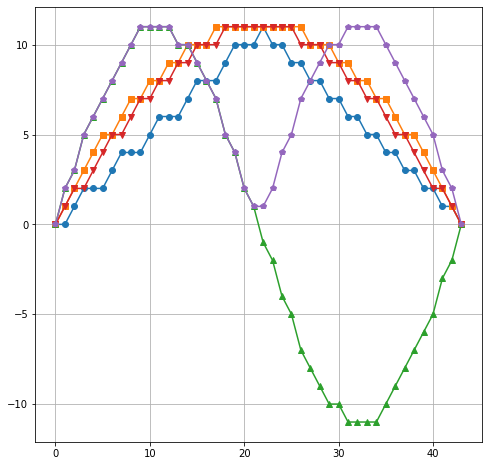

In [0]:
triangle = triangle_shifts(right - left, int(np.round((right - left) / 2)), int(np.round((right - left) / 4)))
parabolic = parabolic_shifts(right - left, int(np.round((right - left) / 4)))
sin = sin_shifts(right - left, int(np.round((right - left) / 4)))
half_sin = half_sin_shifts(right - left, int(np.round((right - left) / 4)))
mod_sin = mod_sin_shifts(right - left, int(np.round((right - left) / 4)))

plt.figure(figsize=(8, 8))
plt.plot(triangle, "o-", label="triangle")
plt.plot(parabolic, "s-", label="parabolic")
plt.plot(sin, "^-", label="sin")
plt.plot(half_sin, "v-", label="half sin")
plt.plot(mod_sin, "p-", label="mod sin")
plt.grid()
plt.show()
plt.close()